In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Convienience Functions

The following graph-printing function was copied from https://github.com/JWarmenhoven/ISLR-python

In [2]:
import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In [3]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    dot_data = StringIO()
    export_graphviz(estimator, 
                    out_file=dot_data, 
                    feature_names=features, 
                    class_names=class_names, 
                    filled=filled)
    
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    
    return graph 

In [4]:
HITTERS_DATA = '../datasets/Hitters.csv'

In [5]:
df = pd.read_csv(HITTERS_DATA)
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


### Explanation of Feature Names

**AtBat** 

    Number of times at bat in 1986

**Hits** 
    
    Number of hits in 1986

**HmRun** 
    
    Number of home runs in 1986

**Runs**

    Number of runs in 1986

**RBI**

    Number of runs batted in 1986

**Walks**

    Number of walks in 1986

**Years**

    Number of years in the major leagues

**CAtBat**

    Number of times at bat during his career

**CHits**

    Number of hits during his career

**CHmRun**

    Number of home runs during his career

**CRuns**

    Number of runs during his career

**CRBI**

    Number of runs batted in during his career

**CWalks**

    Number of walks during his career

**League**

    A factor with levels A and N indicating player's league at the end of 1986

**Division**

    A factor with levels E and W indicating player's division at the end of 1986

**PutOuts**

    Number of put outs in 1986

**Assists**

    Number of assists in 1986

**Errors**

    Number of errors in 1986

**Salary**

    1987 annual salary on opening day in thousands of dollars

**NewLeague**

    A factor with levels A and N indicating player's league at the beginning of 1987


## Drop Rows with NaNs

In [6]:
df = df.dropna()
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


## Log-Transform Salary Values 

In [7]:
# Salary measured in thousands of dollars
df['Salary'].describe().reset_index()

,index,Salary
0,count,263.000000
1,mean,535.925882
2,std,451.118681
3,min,67.500000
4,25%,190.000000
5,50%,425.000000
6,75%,750.000000
7,max,2460.000000


In [8]:
df['log_salary'] = np.log(df['Salary'].values)

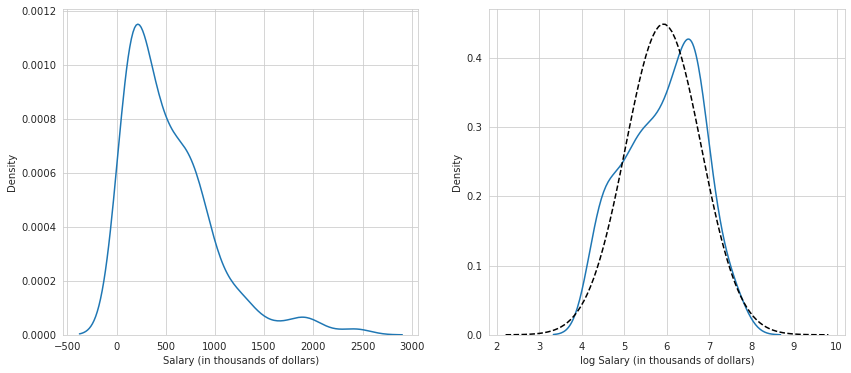

In [9]:
from scipy.stats import norm


min_log_sal = df['log_salary'].min()
max_log_sal = df['log_salary'].max()
mu_log_sal = df['log_salary'].mean()
sd_log_sal = df['log_salary'].std()

sal_grid = np.linspace(min_log_sal - 2.0, max_log_sal + 2.0, num=100)
norm_sal_vals = norm.pdf(x=sal_grid, loc=mu_log_sal, scale=sd_log_sal)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(df['Salary'], ax=ax1)

ax1.set_xlabel('Salary (in thousands of dollars)')
ax1.set_ylabel('Density')

sns.kdeplot(df['log_salary'], ax=ax2)
ax2.plot(sal_grid, norm_sal_vals, 'k--')

ax2.set_xlabel('log Salary (in thousands of dollars)')
ax2.set_ylabel('Density')

plt.show()

## First Regression Tree

We use `Years` and `Hits` to predict the `log_salary` of a player.

In [10]:
df[['log_salary', 'Years', 'Hits']].head()

,log_salary,Years,Hits
1,6.163315,14,81
2,6.173786,3,130
3,6.214608,11,141
4,4.516339,2,87
5,6.620073,11,169


In [11]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Years', 'Hits']].copy().values
y = df['log_salary'].values

model = DecisionTreeRegressor(max_leaf_nodes=3)
model.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

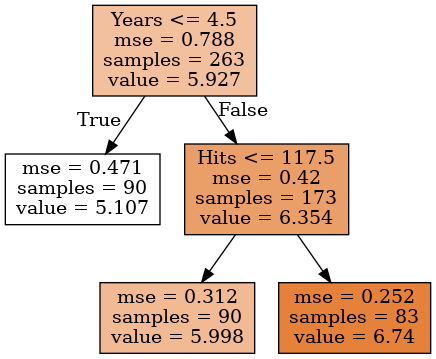

In [12]:
graph = print_tree(model, features=['Years', 'Hits'])

Image(graph[0].create_png())

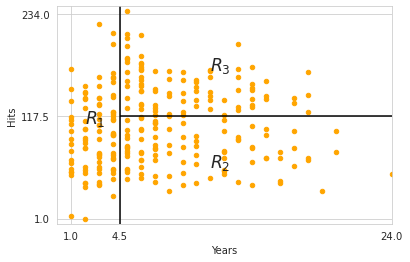

In [13]:
df.plot('Years', 'Hits', kind='scatter', color='orange')

max_year = df['Years'].max()
max_hits = df['Hits'].max()

plt.xlim(0, max_year)
plt.ylim(-5, max_hits + 5)

plt.xticks([1, 4.5, max_year])
plt.yticks([1, 117.5, 234])

plt.vlines(4.5, ymin=-5, ymax=max_hits + 5, color='k')
plt.hlines(117.5, xmin=4.5, xmax=max_year, color='k')

plt.annotate(r'$R_1$', xy=(2, 110), fontsize='xx-large')
plt.annotate(r'$R_2$', xy=(11, 60), fontsize='xx-large')
plt.annotate(r'$R_3$', xy=(11, 170), fontsize='xx-large')

plt.show()

## Pruning Regression Trees

We first grow a full-sized tree using the nine features mentioned in the book.  

In [14]:
df.columns

Index(['Unnamed: 0', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years',
       'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague',
       'log_salary'],
      dtype='object')

In [15]:
features = ['Years', 'RBI', 'Hits', 'Walks', 'PutOuts', 
            'Runs', 'Errors', 'AtBat', 'HmRun', 
            'CHits', 'CHmRun', 'CRBI']
response = 'log_salary'

df_test = df.sample(n=131)
df_train = df[~df.index.isin(df_test.index)]

X_train = df_train[features]
y_train = df_train[response]

X_test = df_test[features]
y_test = df_test[response]

The code that follows has been adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [16]:
model_2 = DecisionTreeRegressor(random_state=0)
path = model_2.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [17]:
models = []

for ccp_alpha in ccp_alphas:
    m = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    m.fit(X_train, y_train)
    models.append(m)


print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(models[-1].tree_.node_count, 
                                                                          ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.4282812644521803


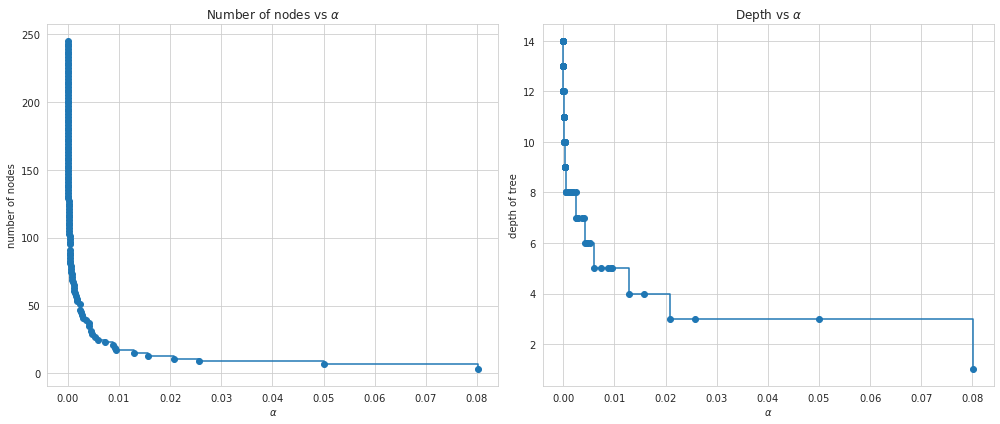

In [18]:
models = models[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [m.tree_.node_count for m in models]
depth = [m.tree_.max_depth for m in models]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel("number of nodes")
ax[0].set_title(r"Number of nodes vs $\alpha$")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel("depth of tree")
ax[1].set_title(r"Depth vs $\alpha$")

fig.tight_layout()

### Accuracy Vs Alpha for Training and Test Sets

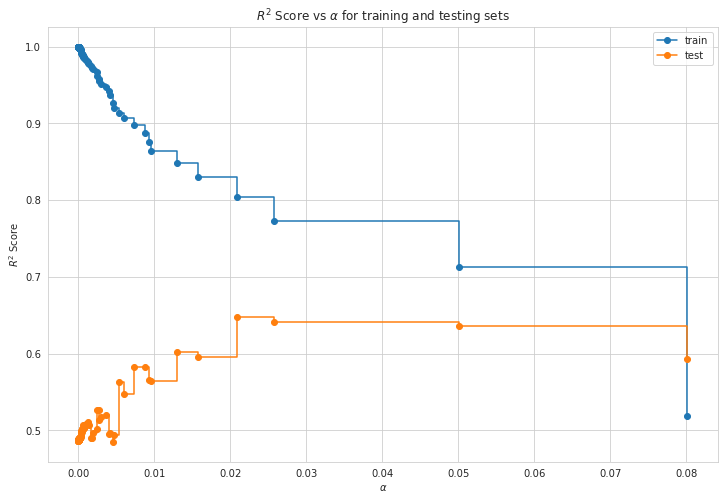

In [19]:
train_scores = [m.score(X_train, y_train) for m in models]
test_scores = [m.score(X_test, y_test) for m in models]

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$R^2$ Score")
ax.set_title(r"$R^2$ Score vs $\alpha$ for training and testing sets")

ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")

ax.legend()

plt.show()

### Accuracy Vs Node Counts for Training and Test Sets

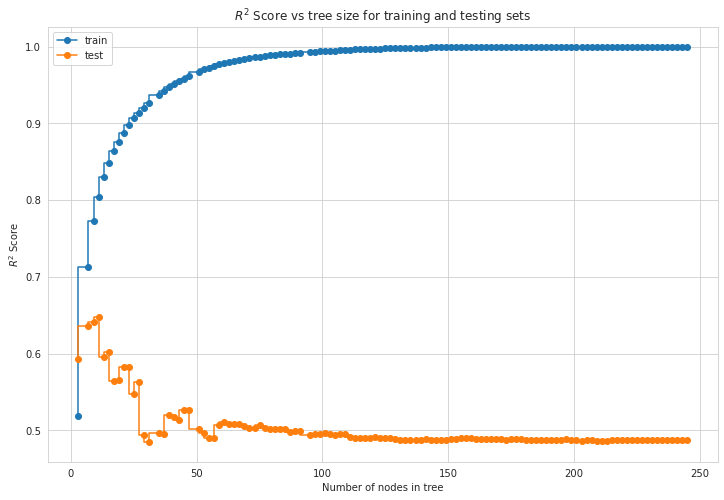

In [20]:
node_counts = [m.tree_.node_count for m in models]

train_scores = [m.score(X_train, y_train) for m in models]
test_scores = [m.score(X_test, y_test) for m in models]

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r"Number of nodes in tree")
ax.set_ylabel("$R^2$ Score")
ax.set_title(r"$R^2$ Score vs tree size for training and testing sets")

ax.plot(node_counts, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(node_counts, test_scores, marker='o', label="test", drawstyle="steps-post")

ax.legend()

plt.show()